# Simulation Based Inference

In this example we will go through an example setting up Nested Sampling as an external sampler for the `sbi` package. This uses the ability to integrate torch with `blackjax`, as detailed more in [PyTorch language integration](../integrations/pytorch.ipynb)

## Neural Likelihood Estimation with Nested Sampling

This example demonstrates how to use BlackJAX nested sampling as a posterior sampler for simulation-based inference (SBI) with neural likelihood estimation (NLE).

## NSPosterior Implementation

First, we define a custom posterior class that uses BlackJAX nested sampling to sample from the posterior distribution given a trained likelihood estimator and prior.

## Prerequisites

Install the required dependencies:

In [ ]:
!pip install git+https://github.com/handley-lab/blackjax
!pip install sbi torch anesthetic numpy tqdm

In [1]:
from typing import Optional

import torch
import numpy as np
import jax
import jax.numpy as jnp
import blackjax
from blackjax.ns.utils import finalise
import anesthetic
import tqdm
from sbi.inference.posteriors.base_posterior import NeuralPosterior
from sbi.inference.potentials.likelihood_based_potential import LikelihoodBasedPotential


class NSPosterior(NeuralPosterior):
    """Nested Sampling posterior for sbi.
    
    Uses BlackJAX nested sampling to sample from posterior distributions
    when given a likelihood estimator and prior.
    
    Args:
        likelihood: Trained likelihood estimator from NLE
        prior: Prior distribution
        num_live: Number of live points for nested sampling
        num_inner_steps: Number of slice sampling steps
        x_o: Observed data (can be set later with set_default_x)
        num_delete: Number of points to delete per iteration (default: 1)
    """
    
    def __init__(
        self,
        likelihood,
        prior,
        num_live,
        num_inner_steps,
        x_o=None,
        num_delete=1,
    ):
        self.num_live = num_live
        self.num_delete = num_delete
        self.num_inner_steps = num_inner_steps
        
        potential_fn = LikelihoodBasedPotential(likelihood, prior, x_o)
        super().__init__(potential_fn)
    
    def _loglikelihood_fn(self, theta):
        x_o_batch = self.default_x.unsqueeze(0).expand(1, theta.shape[0], -1)
        return self.potential_fn.likelihood_estimator.log_prob(x_o_batch, condition=theta).squeeze(0)
    
    def _logprior_fn(self, theta):
        return self.potential_fn.prior.log_prob(theta)
    
    def nested_samples(self) -> anesthetic.NestedSamples:
        """Run BlackJAX nested sampling and return anesthetic NestedSamples object.
        
        Returns:
            NestedSamples object containing particles, log-likelihoods, and birth 
            log-likelihoods that can be used for evidence calculation and diagnostics.
        """
        def wrap_fn(fn, vmap_method='legacy_vectorized'):
            def numpy_wrapper(theta):
                x = torch.from_numpy(np.asarray(theta).copy()).float()
                result = fn(x)
                return result.detach().numpy()
            
            def jax_wrapper(x):
                out_shape = jax.ShapeDtypeStruct(x.shape[:-1], x.dtype)
                return jax.pure_callback(numpy_wrapper, out_shape, x, vmap_method=vmap_method)
            
            return jax_wrapper
        
        algo = blackjax.nss(
            logprior_fn=wrap_fn(self._logprior_fn),
            loglikelihood_fn=wrap_fn(self._loglikelihood_fn),
            num_delete=self.num_delete,
            num_inner_steps=self.num_inner_steps,
        )
        prior_samples = self.potential_fn.prior.sample((self.num_live,))
        initial_live = jnp.array(prior_samples.numpy())
        
        rng_key = jax.random.PRNGKey(42)
        live = algo.init(initial_live)
        step = jax.jit(algo.step)
        
        dead_points = []
        
        with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
            while (not live.logZ_live - live.logZ < -3):
                rng_key, subkey = jax.random.split(rng_key)
                live, dead = step(subkey, live)
                dead_points.append(dead)
                pbar.update(len(dead.particles))

        ns_run = finalise(live, dead_points)
        
        return anesthetic.NestedSamples(
            data=ns_run.particles,
            logL=ns_run.loglikelihood,
            logL_birth=ns_run.loglikelihood_birth,
        )
    
    def sample(
        self,
        sample_shape: torch.Size = torch.Size(),
        x: Optional[torch.Tensor] = None,
        **kwargs
    ) -> torch.Tensor:
        r"""Return samples from posterior distribution $p(\theta|x)$ with nested sampling.
        
        Check the `__init__()` method for a description of all arguments as well as
        their default values.
        
        Args:
            sample_shape: Desired shape of samples that are drawn from posterior. If
                sample_shape is multidimensional we simply draw `sample_shape.numel()`
                samples and then reshape into the desired shape.
                
        Returns:
            Samples from posterior with shape `(*sample_shape, theta_dim)`.
        """
        self.potential_fn.set_x(self._x_else_default_x(x))
        ns = self.nested_samples()
        samples = ns.sample(torch.Size(sample_shape).numel())
        samples_array = samples.drop(columns=['logL', 'logL_birth', 'nlive']).values
        return torch.from_numpy(samples_array).reshape((*sample_shape, -1))
    
    
    def sample_batched(self, sample_shape, x, **kwargs):
        raise NotImplementedError("Batched sampling not available for nested sampling.")

/Users/yallup/projects/nested-sampling-book/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example: Sequential Neural Likelihood Estimation (SNLE)

Now let's use the NSPosterior class with neural likelihood estimation from the sbi package. This example demonstrates sequential neural likelihood estimation (SNLE), where the likelihood estimator is trained over multiple rounds using nested sampling to generate proposal samples for each round.

In [ ]:
from sbi.inference import NLE
from sbi.utils import BoxUniform

num_dims = 2
num_sims = 1000
num_rounds = 2
prior = BoxUniform(low=torch.zeros(num_dims), high=torch.ones(num_dims))
simulator = lambda theta: theta + torch.randn_like(theta) * 0.1
x_o = torch.tensor([0.5, 0.5])

inference = NLE(prior)
proposal = prior

round_samples = []

for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    likelihood = inference.append_simulations(theta, x).train()
    posterior = NSPosterior(
        likelihood, prior, num_live=500, num_inner_steps=20, num_delete=250
    )
    proposal = posterior.set_default_x(x_o)
    round_samples.append(theta)

 Neural network successfully converged after 118 epochs.

Dead points: 2500 dead points [00:05, 434.83 dead points/s]


 Neural network successfully converged after 73 epochs.

## Analyze Results with Anesthetic

Get the nested samples as an anesthetic NestedSamples object for analysis and visualization.

In [3]:
nested_samples = posterior.nested_samples()
nested_samples.to_csv("nested_samples.csv")
print(f"Evidence: {nested_samples.logZ(100).mean() :.2f} ± {nested_samples.logZ(100).std() :.2f}")

Dead points: 2250 dead points [00:05, 436.69 dead points/s]

Evidence: -0.19 ± 0.07


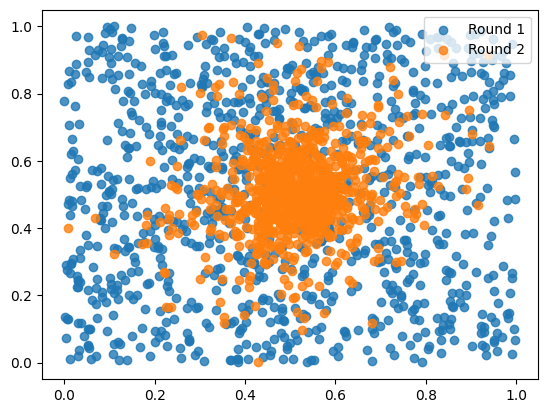

In [4]:
import matplotlib.pyplot as plt
for i,ts in enumerate(round_samples):
    plt.scatter(ts[:, 0], ts[:, 1], alpha=0.8, label=f"Round {i+1}") 
plt.legend()

## Visualize with Anesthetic

The nested samples can be visualized using anesthetic's plotting capabilities. You can either:

1. Use anesthetic from the command line:
```bash
anesthetic nested_samples.csv
```

2. Or plot directly in Python:
```python
import matplotlib.pyplot as plt

# Create corner plot
fig = nested_samples.plot_2d([0, 1])
plt.show()

# Plot the log-evidence progression
fig, ax = plt.subplots()
ax.plot(nested_samples.logZ())
ax.set_xlabel('Iteration')
ax.set_ylabel('log(Z)')
plt.show()
```